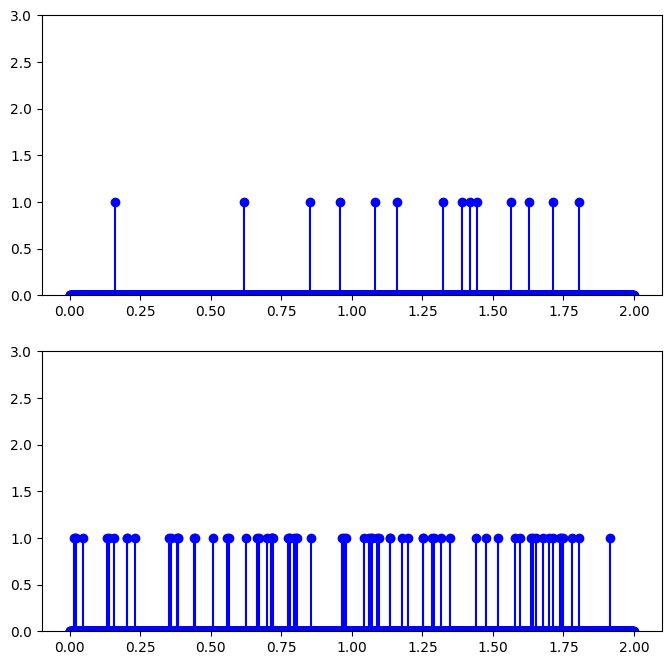

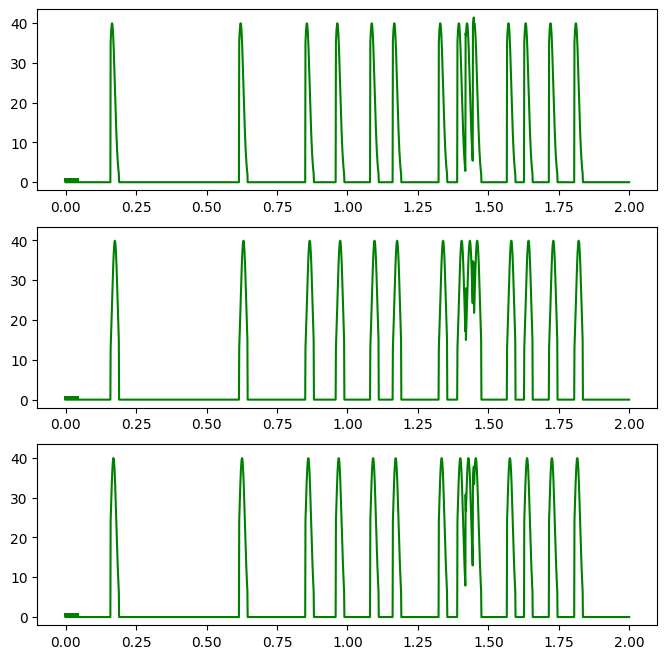

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

%run ../src/models/losses.py
%run ../src/data/data_generator.py

losses = Losses()
loss_function = losses.total_loss

In [5]:
class DeconvolutionDiffusion(DataGenerator, nn.Module):
    def __init__(self, sources, channels, duration, sampling_frequency, num_steps=10, noise_std=0.05):
        DataGenerator.__init__(self, sources, channels, duration, sampling_frequency)
        nn.Module.__init__(self)

        self.n, self.m, self.T = sources, channels, self.num_samples
        self.num_steps = num_steps
        self.noise_std = noise_std

        # Process time domain (full length T)
        self.encoder_time = nn.Sequential(
            nn.Conv1d(channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # Process frequency domain (length T//2 + 1)
        self.encoder_freq = nn.Sequential(
            nn.Conv1d(channels * 2, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # Decoder that combines both features
        self.decoder = nn.Sequential(
            nn.Conv1d(64 + 64, 64, kernel_size=3, padding=1),  # Combine features
            nn.ReLU(),
            nn.Conv1d(64, sources, kernel_size=3, padding=1),
        )

    def forward(self, Y_c, c):
        if Y_c.dim() == 2:
            Y_c = Y_c.unsqueeze(0)

        # Time domain processing
        x_time = self.encoder_time(Y_c)  # (batch, 64, T)

        # Frequency domain processing
        Y_fft = torch.fft.rfft(Y_c, dim=-1)  # Complex tensor
        Y_freq = torch.cat([Y_fft.real, Y_fft.imag], dim=1)
        x_freq = self.encoder_freq(Y_freq)  # (batch, 64, T//2 + 1)

        # Interpolate frequency features to match time domain
        x_freq = F.interpolate(x_freq, size=x_time.shape[-1], mode='linear')

        # Combine features
        x_combined = torch.cat([x_time, x_freq], dim=1)
        
        # Decode to source signals
        x = self.decoder(x_combined)

        # Always ensure outputs are between 0 and 1
        x = torch.sigmoid(x)
        
        if c == self.num_steps:
            x = (x > 0).to(torch.float32) # Then threshold to get binary values
        
        return x.squeeze(0)
    
    def generate_filters(self, mu_H, sigma_H, L):
        """Generate positive sinusoidal filters instead of Gaussian."""
        H = np.zeros((self.num_channels, self.num_sources, L))
        t = np.linspace(0, 2*np.pi, L)
        
        for i in range(self.num_channels):
            for j in range(self.num_sources):
                # Create a positive sinusoidal filter
                freq = mu_H[i,j]  # Use mu_H as frequency parameter
                phase = sigma_H[i,j] * 2 * np.pi  # Use sigma_H for phase variation
                H[i,j,:] = np.maximum(0, np.sin(freq * t + phase))  # Ensure positive
                
                # Normalize the filter
                if np.sum(H[i,j,:]) > 0:
                    H[i,j,:] /= np.sum(H[i,j,:])
        
        return H
    
    def add_noise(self, X, mu_H, sigma_H, L):
        """
        Iteratively applies convolutional noise.

        Returns two lists:
        - Y_channel: List of (channels, T) tensors for input to the model
        - Y_source: List of (sources, T) tensors for comparison/generation
        """
        T = self.num_samples
        # incremental_data = DataGenerator(self.num_sources, self.num_channels, self.duration, self.sampling_frequency)

        X = torch.tensor(X, dtype=torch.float32)
        Y_source = [X.clone().numpy()]  # First source signal (sources, T)
        Y_channel = []  # Will store channel versions (channels, T)

        for c in range(1, self.num_steps + 1):
            H = self.generate_filters(mu_H, sigma_H, L)

            # Perform convolution to get (channels, T)
            Y_next = np.zeros((self.num_channels, T))
            for i in range(self.num_channels):
                for j in range(self.num_sources):
                    # Use the last added source signal for convolution
                    Y_next[i, :] += np.convolve(Y_source[-1][j, :], H[i, j, :], mode='same')

            # Add noise to (channels, T)
            noise = np.random.randn(*Y_next.shape) * self.noise_std
            Y_next += noise
            
            # Store the channel version
            Y_channel.append(Y_next)
            
            # Create and store the source version for next iteration
            Y_source_next = Y_next[:self.num_sources, :] # Take first n rows for source version
            Y_source.append(Y_source_next)

        # Convert to tensors and reverse lists
        Y_channel = [torch.tensor(y, dtype=torch.float32) for y in reversed(Y_channel)]
        Y_source = [torch.tensor(y, dtype=torch.float32) for y in reversed(Y_source)]
        
        return Y_channel, Y_source

    def generate_training_data(self):
        """Generate training spike trains and noisy sequences."""
        firing_rates = np.random.uniform(0.1, 1, size=self.num_sources)  
        mu_H = np.random.uniform(0, 5, size=(self.num_channels, self.num_sources))
        sigma_H = np.random.uniform(0.5, 2.0, size=(self.num_channels, self.num_sources))
        filter_length = 5  

        Y0, X = self.generate_data(firing_rates, filter_length, mu_H, sigma_H)
        X = torch.tensor(X, dtype=torch.float32) 
        X = (X > 0).float()  # Ensure source signals are binary

        # Ensure X has the correct shape (num_sources, num_samples)
        if X.shape != (self.num_sources, self.num_samples):
            raise ValueError(f"Expected X to have shape ({self.num_sources}, {self.num_samples}), got {X.shape}")

        Y_channel, Y_source = self.add_noise(X, mu_H, sigma_H, filter_length)
        return Y_channel, Y_source
    
def train_model(model, max_iterations=10000, test_freq=100, lr=0.001):
    """Train the diffusion model with continuous data generation"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=20,
        verbose=True
    )
    
    loss_fn = losses.total_loss
    max_grad_norm = 0.5

    # Initialize tracking variables
    start_time = time.time()
    losses_history = []
    best_loss = float('inf')
    patience_counter = 0
    patience = 50
    
    iteration = 0
    while iteration < max_iterations:
        try:
            model.train()
            optimizer.zero_grad()
            
            # Generate and normalize training data
            Y_channel, Y_source = model.generate_training_data()
            
            # Normalize inputs
            for i in range(len(Y_channel)):
                Y_channel[i] = (Y_channel[i] - Y_channel[i].mean()) / (Y_channel[i].std() + 1e-8)
                Y_source[i] = (Y_source[i] - Y_source[i].mean()) / (Y_source[i].std() + 1e-8)
            
            # Progressive loss
            sample_loss = 0
            for c in range(1, model.num_steps + 1):
                Y_pred = model(Y_channel[c-1], c)
                
                # Add batch dimension before computing loss
                Y_pred_batched = Y_pred.unsqueeze(0)
                Y_source_batched = Y_source[c].unsqueeze(0)
                
                # Weight loss more heavily for later steps
                if c == model.num_steps:
                    step_weight = 10.0  # Much higher weight for final step
                else:
                    step_weight = c / model.num_steps
                
                step_loss = losses.hungarian_loss(Y_pred_batched, Y_source_batched, loss_fn=loss_fn)
                sample_loss += step_weight * step_loss
                
                del Y_pred, Y_pred_batched, Y_source_batched
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
            
            # Normalize the loss
            sample_loss = sample_loss / model.num_steps
            
            # Check for NaN loss
            if not torch.isnan(sample_loss):
                sample_loss.backward()
                
                # Clip gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                
                # Check for NaN gradients
                has_nan_grad = False
                for param in model.parameters():
                    if param.grad is not None and torch.isnan(param.grad).any():
                        has_nan_grad = True
                        break
                
                if not has_nan_grad:
                    optimizer.step()
                else:
                    print(f"NaN gradient detected in iteration {iteration}, skipping...")
            else:
                print(f"NaN loss detected in iteration {iteration}, skipping...")
            
            # Testing and logging
            if iteration % test_freq == 0:
                current_loss = sample_loss.item()
                losses_history.append(current_loss)
                
                # Learning rate scheduling
                scheduler.step(current_loss)
                
                # Early stopping check
                if current_loss < best_loss:
                    best_loss = current_loss
                    best_model_state = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered after {iteration} iterations")
                    model.load_state_dict(best_model_state)
                    break
                
                # Logging
                elapsed = time.time() - start_time
                print(f"\nIteration {iteration}/{max_iterations}")
                print(f"Loss: {current_loss:.4f}")
                print(f"Best Loss: {best_loss:.4f}")
                print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
                print(f"Elapsed: {timedelta(seconds=int(elapsed))}")
                print("-" * 50)
                
                if iteration % (test_freq * 10) == 0:
                    plt.figure(figsize=(10, 5))
                    plt.plot(losses_history, label='Loss')
                    plt.title('Loss History')
                    plt.xlabel('Test Step')
                    plt.ylabel('Loss')
                    plt.yscale('log')
                    plt.legend()
                    plt.grid(True)
                    plt.show()
            
            # Clean up
            del Y_channel, Y_source, sample_loss
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                
        except RuntimeError as e:
            print(f"Error in iteration {iteration}: {str(e)}")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            continue
            
        iteration += 1

    return model, losses_history

def test_model(model, num_tests=10):
    """Test model on new data and compute Hungarian loss between final prediction and original signal."""
    model.eval()
    loss_fn = losses.total_loss
    total_loss = 0

    examples = []

    with torch.no_grad():
        for _ in range(num_tests):
            Y_channel, Y_source = model.generate_training_data() 

            print(f"Test shapes:")
            print(f"Y_channel[0] shape: {Y_channel[0].shape}")
            print(f"Y_source[0] shape: {Y_source[0].shape}")

            original_signal = Y_source[-1]  # The original clean signal
            Y_current = Y_channel[0]  # Most noisy version (channels, T)
            
            # Store denoising evolution
            evolution = [Y_current.numpy()]
            
            # Perform iterative denoising
            for c in range(model.num_steps, 0, -1):
                # Get prediction (sources, T)
                Y_pred = model(Y_current, c)
                
                if c > 1:
                    # For intermediate steps, pad back to channel dimensions
                    Y_current = torch.zeros_like(Y_channel[0])  # (channels, T)
                    Y_current[:model.n] = Y_pred[:model.n]  # Copy source predictions
                    Y_current[model.n:] = Y_channel[c-1][model.n:]  # Copy remaining channels from next noisy version
                else:
                    # For final step, keep only source predictions
                    Y_current = Y_pred[:model.n]
                
                evolution.append(Y_current.numpy())
            
            # Add batch dimension before computing loss
            Y_current_batched = Y_current.unsqueeze(0)  # (1, sources, T)
            original_signal_batched = original_signal.unsqueeze(0)  # (1, sources, T)
            
            # Print shapes for debugging
            print(f"Final prediction shape: {Y_current_batched.shape}")
            print(f"Original signal shape: {original_signal_batched.shape}")
            
            # Compute loss only between final prediction and original signal
            final_loss = losses.hungarian_loss(Y_current_batched, original_signal_batched, loss_fn=loss_fn)
            total_loss += final_loss.item()
            
            # Store example
            examples.append({
                'noisy': Y_channel[0].numpy(),
                'evolution': evolution,
                'true': original_signal.numpy()
            })

    avg_loss = total_loss / num_tests
    print(f"\nAverage Loss on Test Set: {avg_loss:.4f}")
    
    return examples

def plot_denoising_evolution(example, model, figsize=(15, 8)):
    """Plot the evolution of the denoising process for one example."""
    
    evolution = example['evolution']
    num_steps = len(evolution)
    
    # First step has channel dimensions, rest have source dimensions
    first_step_channels = evolution[0].shape[0]
    num_sources = model.n
    
    # Create figure with two sections
    fig = plt.figure(figsize=figsize)
    gs = plt.GridSpec(2, 1, height_ratios=[first_step_channels, num_sources*2])
    
    # Top subplot for initial noisy channels
    ax_channels = fig.add_subplot(gs[0])
    for i in range(first_step_channels):
        ax_channels.plot(evolution[0][i], label=f'Channel {i+1}')
    ax_channels.set_title('Initial Noisy Channels')
    ax_channels.legend()
    ax_channels.grid(True)
    
    # Bottom subplot for source evolution
    ax_sources = fig.add_subplot(gs[1])
    colors = plt.cm.rainbow(np.linspace(0, 1, num_sources))
    
    for i in range(num_sources):
        # Plot evolution for each source
        for j in range(1, num_steps):  # Start from second step
            alpha = j / num_steps  # Later steps more opaque
            ax_sources.plot(evolution[j][i], 
                          color=colors[i], 
                          alpha=alpha, 
                          label=f'Source {i+1}' if j == num_steps-1 else "")
    
    ax_sources.set_title('Source Evolution (Lighter → Darker = Earlier → Later)')
    ax_sources.legend()
    ax_sources.grid(True)
    
    plt.tight_layout()
    return fig

def compare_results(example, figsize=(15, 10)):
    """Compare noisy input, final prediction, and ground truth."""
    
    noisy = example['noisy']      # (channels, T)
    final = example['evolution'][-1]  # (sources, T)
    true = example['true']        # (sources, T)
    
    num_channels = noisy.shape[0]
    num_sources = final.shape[0]
    
    # Create figure with three subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    
    # Plot noisy channels
    ax_noisy = axes[0]
    for i in range(num_channels):
        ax_noisy.plot(noisy[i], label=f'Channel {i+1}')
    ax_noisy.set_title('Noisy Input Channels')
    ax_noisy.legend()
    ax_noisy.grid(True)
    
    # Plot predicted sources
    ax_pred = axes[1]
    for i in range(num_sources):
        ax_pred.plot(final[i], label=f'Source {i+1}')
    ax_pred.set_title('Predicted Sources')
    ax_pred.legend()
    ax_pred.grid(True)
    
    # Plot true sources
    ax_true = axes[2]
    for i in range(num_sources):
        ax_true.plot(true[i], label=f'Source {i+1}')
    ax_true.set_title('True Sources')
    ax_true.legend()
    ax_true.grid(True)
    
    plt.tight_layout()
    return fig

def run_model_with_visualization(model, num_tests=3):
    """Run the model and create visualizations."""
    print("Testing model...")
    examples = test_model(model, num_tests)
    
    print("\nGenerating visualizations...")
    for i, example in enumerate(examples):
        print(f"\nExample {i+1}:")
        
        # Plot denoising evolution
        fig1 = plot_denoising_evolution(example, model)
        plt.show()
        
        # Plot comparison
        fig2 = compare_results(example)
        plt.show()
        
        print("-" * 50)


/home/noura/Documents/Projects/PhD/emg-bss/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/tmp/ipykernel_1239148/2457525931.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)



Iteration 0/10000000
Loss: 10.8787
Best Loss: 10.8787
Learning Rate: 0.001000
Elapsed: 0:00:00
--------------------------------------------------


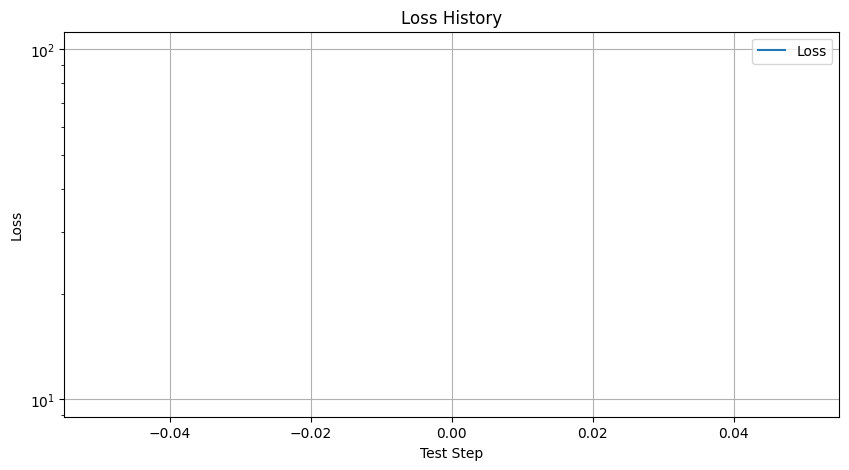


Iteration 100/10000000
Loss: 7.3834
Best Loss: 7.3834
Learning Rate: 0.001000
Elapsed: 0:00:24
--------------------------------------------------

Iteration 200/10000000
Loss: 8.3173
Best Loss: 7.3834
Learning Rate: 0.001000
Elapsed: 0:00:38
--------------------------------------------------

Iteration 300/10000000
Loss: 7.7936
Best Loss: 7.3834
Learning Rate: 0.001000
Elapsed: 0:00:52
--------------------------------------------------

Iteration 400/10000000
Loss: 7.6510
Best Loss: 7.3834
Learning Rate: 0.001000
Elapsed: 0:01:07
--------------------------------------------------

Iteration 500/10000000
Loss: 7.7152
Best Loss: 7.3834
Learning Rate: 0.001000
Elapsed: 0:01:20
--------------------------------------------------

Iteration 600/10000000
Loss: 7.5584
Best Loss: 7.3834
Learning Rate: 0.001000
Elapsed: 0:01:35
--------------------------------------------------

Iteration 700/10000000
Loss: 8.7696
Best Loss: 7.3834
Learning Rate: 0.001000
Elapsed: 0:01:50
----------------------

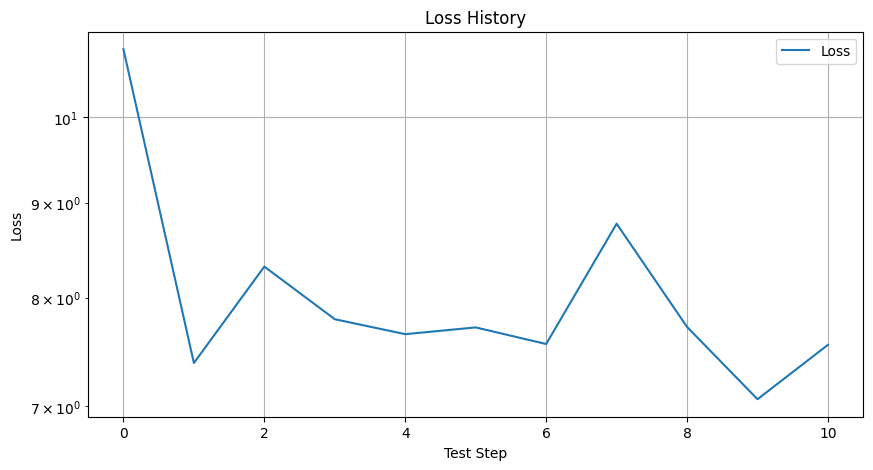


Iteration 1100/10000000
Loss: 8.0270
Best Loss: 7.0603
Learning Rate: 0.001000
Elapsed: 0:02:48
--------------------------------------------------

Iteration 1200/10000000
Loss: 7.0968
Best Loss: 7.0603
Learning Rate: 0.001000
Elapsed: 0:03:03
--------------------------------------------------

Iteration 1300/10000000
Loss: 7.5922
Best Loss: 7.0603
Learning Rate: 0.001000
Elapsed: 0:03:17
--------------------------------------------------

Iteration 1400/10000000
Loss: 7.3035
Best Loss: 7.0603
Learning Rate: 0.001000
Elapsed: 0:03:31
--------------------------------------------------

Iteration 1500/10000000
Loss: 7.5202
Best Loss: 7.0603
Learning Rate: 0.001000
Elapsed: 0:03:45
--------------------------------------------------

Iteration 1600/10000000
Loss: 7.1214
Best Loss: 7.0603
Learning Rate: 0.001000
Elapsed: 0:03:59
--------------------------------------------------

Iteration 1700/10000000
Loss: 7.4582
Best Loss: 7.0603
Learning Rate: 0.001000
Elapsed: 0:04:13
---------------

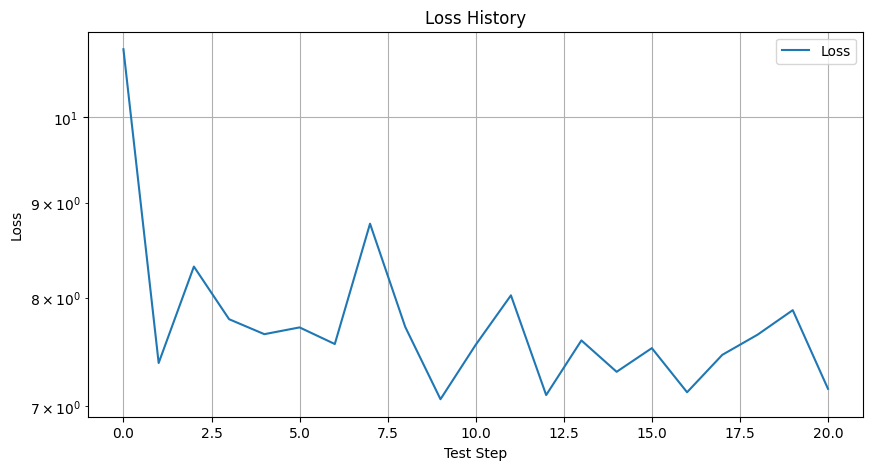


Iteration 2100/10000000
Loss: 7.4761
Best Loss: 7.0603
Learning Rate: 0.001000
Elapsed: 0:05:10
--------------------------------------------------

Iteration 2200/10000000
Loss: 7.6461
Best Loss: 7.0603
Learning Rate: 0.001000
Elapsed: 0:05:24
--------------------------------------------------

Iteration 2300/10000000
Loss: 7.0419
Best Loss: 7.0419
Learning Rate: 0.001000
Elapsed: 0:05:39
--------------------------------------------------

Iteration 2400/10000000
Loss: 7.3201
Best Loss: 7.0419
Learning Rate: 0.001000
Elapsed: 0:05:52
--------------------------------------------------

Iteration 2500/10000000
Loss: 7.4913
Best Loss: 7.0419
Learning Rate: 0.001000
Elapsed: 0:06:06
--------------------------------------------------

Iteration 2600/10000000
Loss: 8.3926
Best Loss: 7.0419
Learning Rate: 0.001000
Elapsed: 0:06:21
--------------------------------------------------

Iteration 2700/10000000
Loss: 7.7142
Best Loss: 7.0419
Learning Rate: 0.001000
Elapsed: 0:06:35
---------------

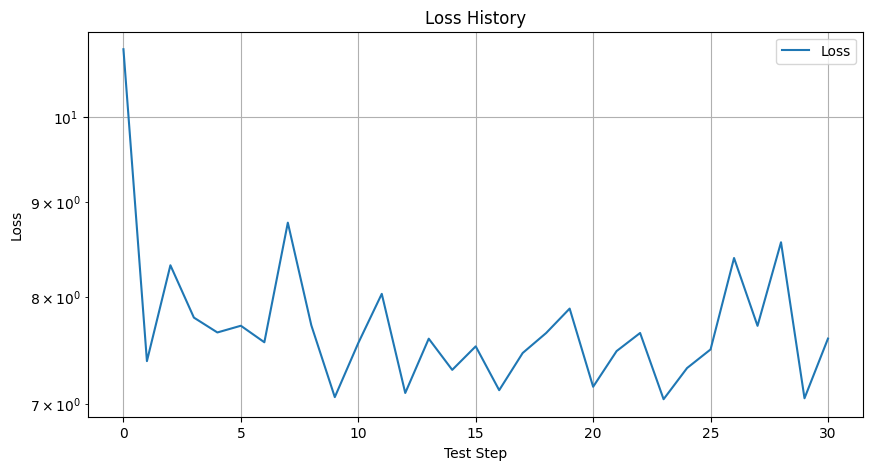


Iteration 3100/10000000
Loss: 7.5676
Best Loss: 7.0419
Learning Rate: 0.001000
Elapsed: 0:07:32
--------------------------------------------------

Iteration 3200/10000000
Loss: 7.8921
Best Loss: 7.0419
Learning Rate: 0.001000
Elapsed: 0:07:46
--------------------------------------------------

Iteration 3300/10000000
Loss: 7.0732
Best Loss: 7.0419
Learning Rate: 0.001000
Elapsed: 0:08:00
--------------------------------------------------

Iteration 3400/10000000
Loss: 7.7413
Best Loss: 7.0419
Learning Rate: 0.001000
Elapsed: 0:08:14
--------------------------------------------------

Iteration 3500/10000000
Loss: 7.8959
Best Loss: 7.0419
Learning Rate: 0.001000
Elapsed: 0:08:28
--------------------------------------------------

Iteration 3600/10000000
Loss: 7.9068
Best Loss: 7.0419
Learning Rate: 0.001000
Elapsed: 0:08:43
--------------------------------------------------

Iteration 3700/10000000
Loss: 7.6110
Best Loss: 7.0419
Learning Rate: 0.001000
Elapsed: 0:08:57
---------------

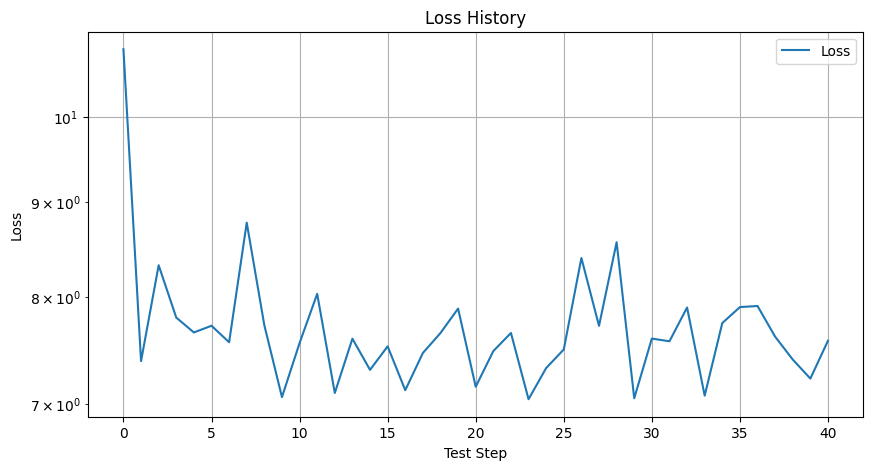


Iteration 4100/10000000
Loss: 7.0787
Best Loss: 7.0419
Learning Rate: 0.001000
Elapsed: 0:09:56
--------------------------------------------------

Iteration 4200/10000000
Loss: 7.4828
Best Loss: 7.0419
Learning Rate: 0.001000
Elapsed: 0:10:11
--------------------------------------------------

Iteration 4300/10000000
Loss: 7.3217
Best Loss: 7.0419
Learning Rate: 0.001000
Elapsed: 0:10:26
--------------------------------------------------

Iteration 4400/10000000
Loss: 7.1936
Best Loss: 7.0419
Learning Rate: 0.000500
Elapsed: 0:10:40
--------------------------------------------------

Iteration 4500/10000000
Loss: 8.4779
Best Loss: 7.0419
Learning Rate: 0.000500
Elapsed: 0:10:55
--------------------------------------------------

Iteration 4600/10000000
Loss: 8.2509
Best Loss: 7.0419
Learning Rate: 0.000500
Elapsed: 0:11:08
--------------------------------------------------

Iteration 4700/10000000
Loss: 7.2241
Best Loss: 7.0419
Learning Rate: 0.000500
Elapsed: 0:11:23
---------------

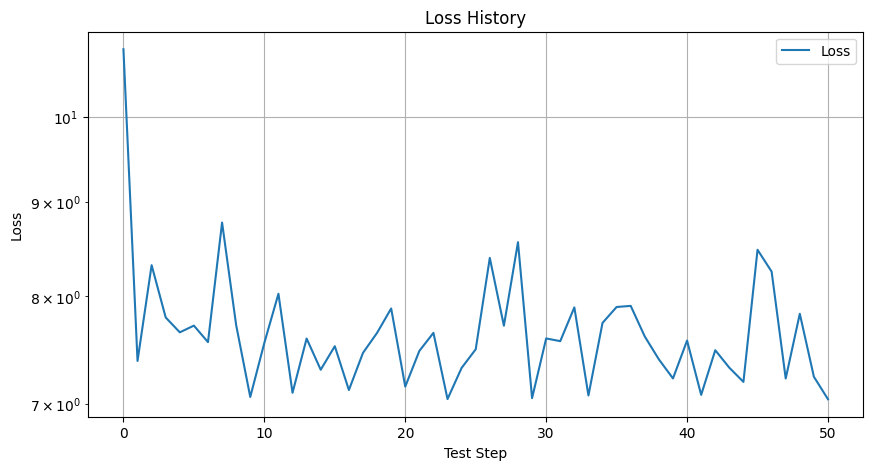


Iteration 5100/10000000
Loss: 7.7569
Best Loss: 7.0405
Learning Rate: 0.000500
Elapsed: 0:12:19
--------------------------------------------------

Iteration 5200/10000000
Loss: 7.5115
Best Loss: 7.0405
Learning Rate: 0.000500
Elapsed: 0:12:33
--------------------------------------------------

Iteration 5300/10000000
Loss: 7.5548
Best Loss: 7.0405
Learning Rate: 0.000500
Elapsed: 0:12:47
--------------------------------------------------

Iteration 5400/10000000
Loss: 7.4574
Best Loss: 7.0405
Learning Rate: 0.000500
Elapsed: 0:13:01
--------------------------------------------------

Iteration 5500/10000000
Loss: 7.9046
Best Loss: 7.0405
Learning Rate: 0.000500
Elapsed: 0:13:15
--------------------------------------------------

Iteration 5600/10000000
Loss: 7.3507
Best Loss: 7.0405
Learning Rate: 0.000500
Elapsed: 0:13:30
--------------------------------------------------

Iteration 5700/10000000
Loss: 8.0567
Best Loss: 7.0405
Learning Rate: 0.000500
Elapsed: 0:13:44
---------------

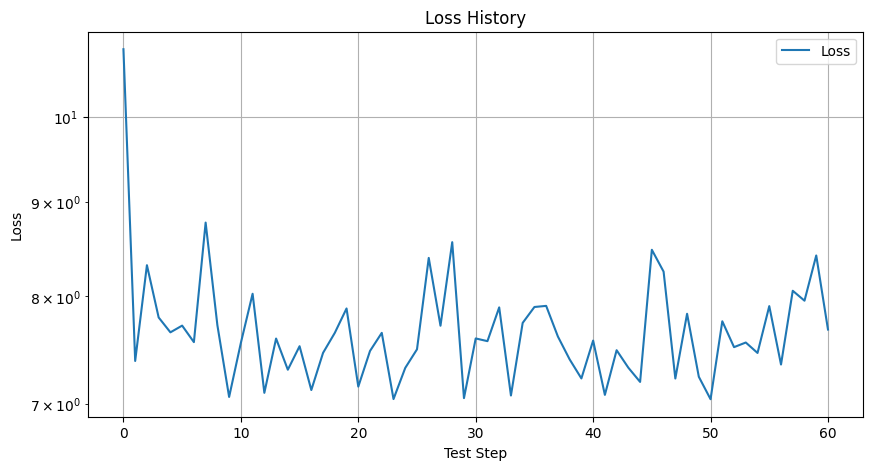


Iteration 6100/10000000
Loss: 8.6396
Best Loss: 7.0405
Learning Rate: 0.000500
Elapsed: 0:14:39
--------------------------------------------------

Iteration 6200/10000000
Loss: 7.3199
Best Loss: 7.0405
Learning Rate: 0.000500
Elapsed: 0:14:54
--------------------------------------------------

Iteration 6300/10000000
Loss: 7.3152
Best Loss: 7.0405
Learning Rate: 0.000500
Elapsed: 0:15:08
--------------------------------------------------

Iteration 6400/10000000
Loss: 7.1305
Best Loss: 7.0405
Learning Rate: 0.000500
Elapsed: 0:15:22
--------------------------------------------------

Iteration 6500/10000000
Loss: 7.6929
Best Loss: 7.0405
Learning Rate: 0.000500
Elapsed: 0:15:37
--------------------------------------------------

Iteration 6600/10000000
Loss: 8.0301
Best Loss: 7.0405
Learning Rate: 0.000500
Elapsed: 0:15:50
--------------------------------------------------

Iteration 6700/10000000
Loss: 7.4397
Best Loss: 7.0405
Learning Rate: 0.000500
Elapsed: 0:16:04
---------------

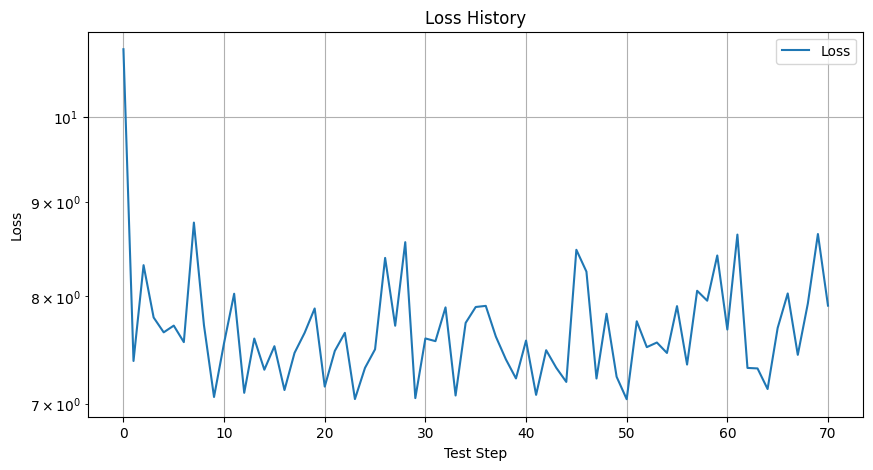


Iteration 7100/10000000
Loss: 7.1251
Best Loss: 7.0405
Learning Rate: 0.000250
Elapsed: 0:17:02
--------------------------------------------------

Iteration 7200/10000000
Loss: 7.8524
Best Loss: 7.0405
Learning Rate: 0.000250
Elapsed: 0:17:17
--------------------------------------------------

Iteration 7300/10000000
Loss: 7.5238
Best Loss: 7.0405
Learning Rate: 0.000250
Elapsed: 0:17:31
--------------------------------------------------

Iteration 7400/10000000
Loss: 7.6153
Best Loss: 7.0405
Learning Rate: 0.000250
Elapsed: 0:17:46
--------------------------------------------------

Iteration 7500/10000000
Loss: 7.9891
Best Loss: 7.0405
Learning Rate: 0.000250
Elapsed: 0:18:00
--------------------------------------------------

Iteration 7600/10000000
Loss: 7.2504
Best Loss: 7.0405
Learning Rate: 0.000250
Elapsed: 0:18:14
--------------------------------------------------

Iteration 7700/10000000
Loss: 8.0331
Best Loss: 7.0405
Learning Rate: 0.000250
Elapsed: 0:18:28
---------------

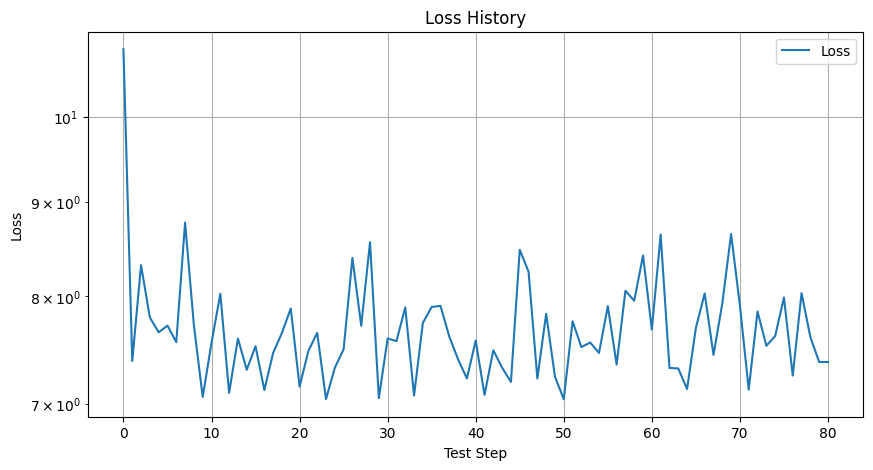


Iteration 8100/10000000
Loss: 7.4437
Best Loss: 7.0405
Learning Rate: 0.000250
Elapsed: 0:19:24
--------------------------------------------------

Iteration 8200/10000000
Loss: 7.4405
Best Loss: 7.0405
Learning Rate: 0.000250
Elapsed: 0:19:37
--------------------------------------------------

Iteration 8300/10000000
Loss: 7.8572
Best Loss: 7.0405
Learning Rate: 0.000250
Elapsed: 0:19:52
--------------------------------------------------

Iteration 8400/10000000
Loss: 7.7377
Best Loss: 7.0405
Learning Rate: 0.000250
Elapsed: 0:20:06
--------------------------------------------------

Iteration 8500/10000000
Loss: 7.2973
Best Loss: 7.0405
Learning Rate: 0.000250
Elapsed: 0:20:21
--------------------------------------------------

Iteration 8600/10000000
Loss: 8.1363
Best Loss: 7.0405
Learning Rate: 0.000250
Elapsed: 0:20:36
--------------------------------------------------

Iteration 8700/10000000
Loss: 7.2476
Best Loss: 7.0405
Learning Rate: 0.000250
Elapsed: 0:20:50
---------------

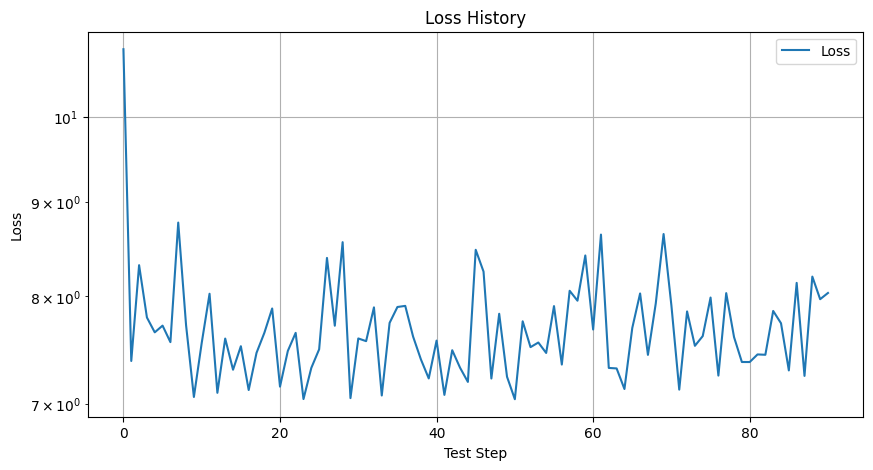


Iteration 9100/10000000
Loss: 7.4905
Best Loss: 7.0405
Learning Rate: 0.000250
Elapsed: 0:21:47
--------------------------------------------------

Iteration 9200/10000000
Loss: 7.9361
Best Loss: 7.0405
Learning Rate: 0.000125
Elapsed: 0:22:01
--------------------------------------------------

Iteration 9300/10000000
Loss: 7.8644
Best Loss: 7.0405
Learning Rate: 0.000125
Elapsed: 0:22:15
--------------------------------------------------

Iteration 9400/10000000
Loss: 7.7322
Best Loss: 7.0405
Learning Rate: 0.000125
Elapsed: 0:22:29
--------------------------------------------------

Iteration 9500/10000000
Loss: 7.3930
Best Loss: 7.0405
Learning Rate: 0.000125
Elapsed: 0:22:44
--------------------------------------------------

Iteration 9600/10000000
Loss: 7.6858
Best Loss: 7.0405
Learning Rate: 0.000125
Elapsed: 0:22:58
--------------------------------------------------

Iteration 9700/10000000
Loss: 7.2630
Best Loss: 7.0405
Learning Rate: 0.000125
Elapsed: 0:23:12
---------------

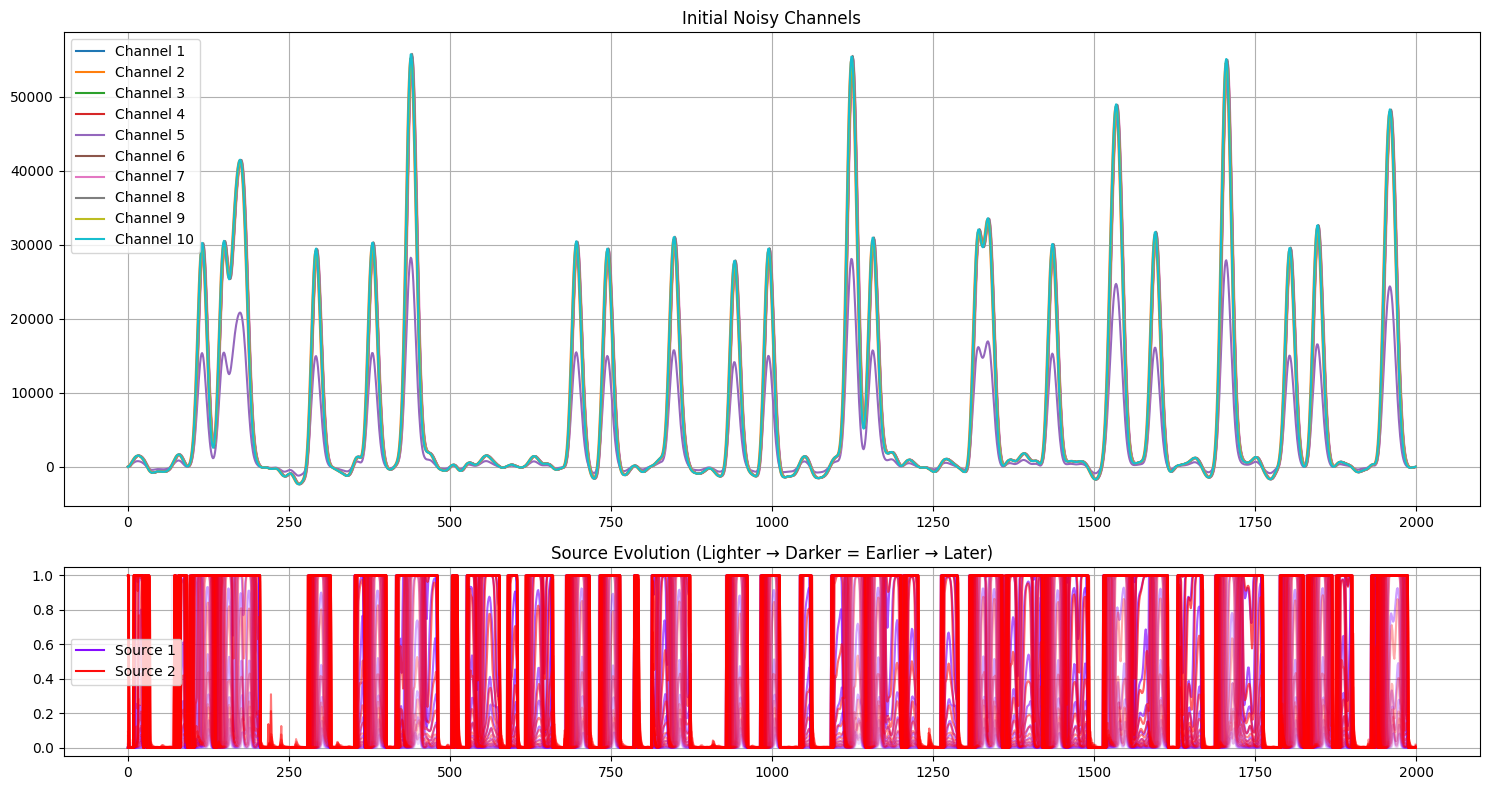

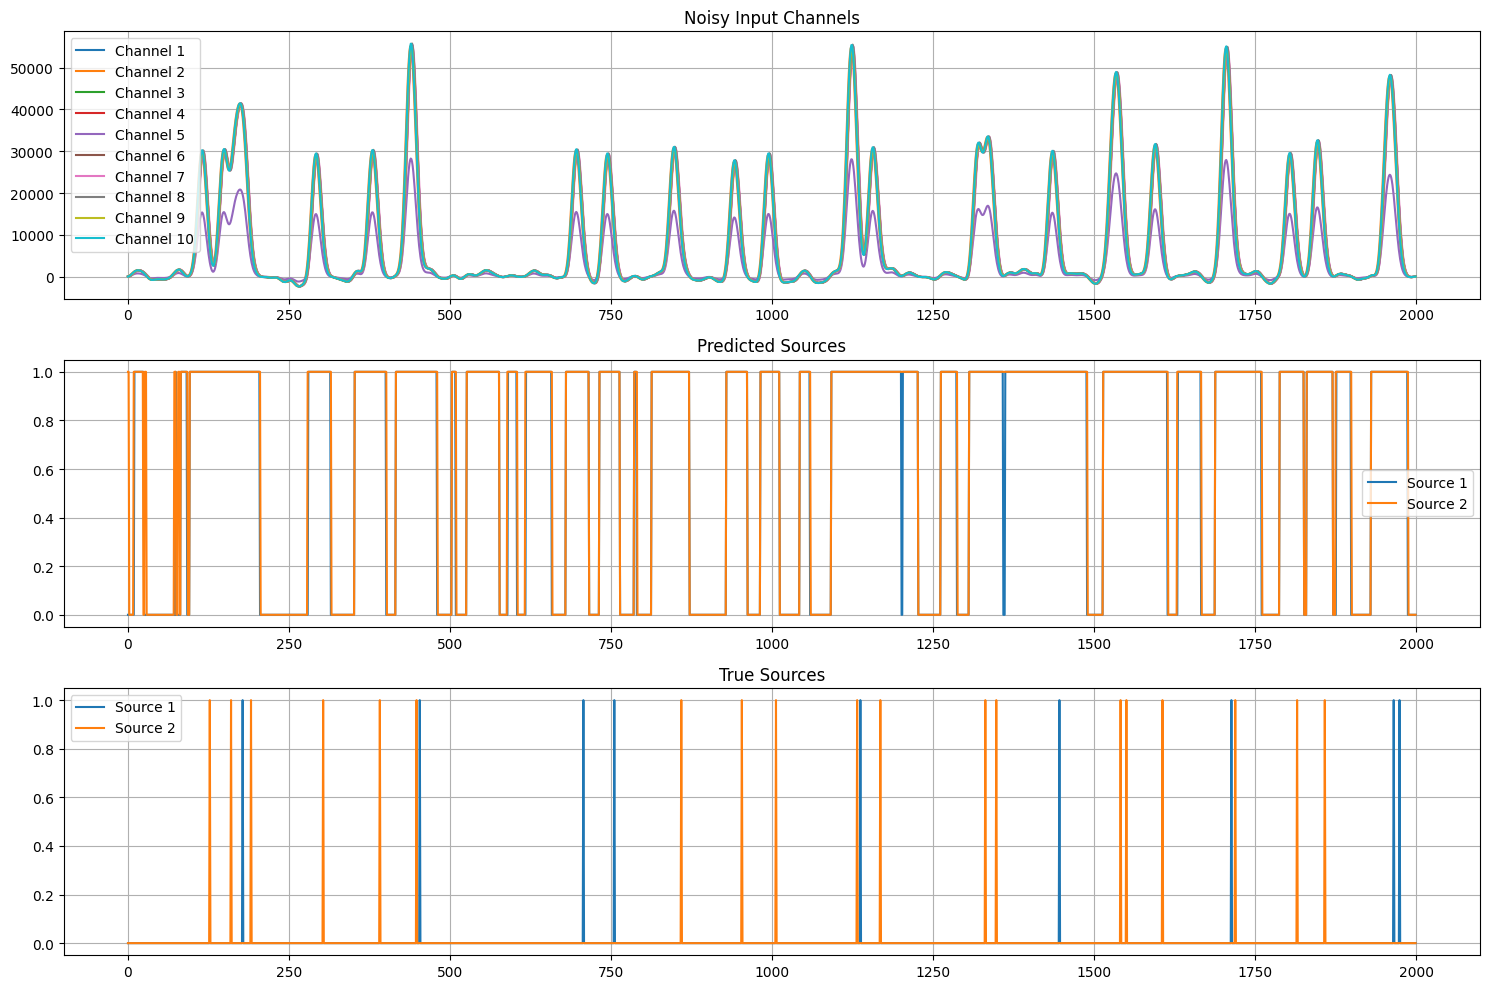

--------------------------------------------------

Example 2:


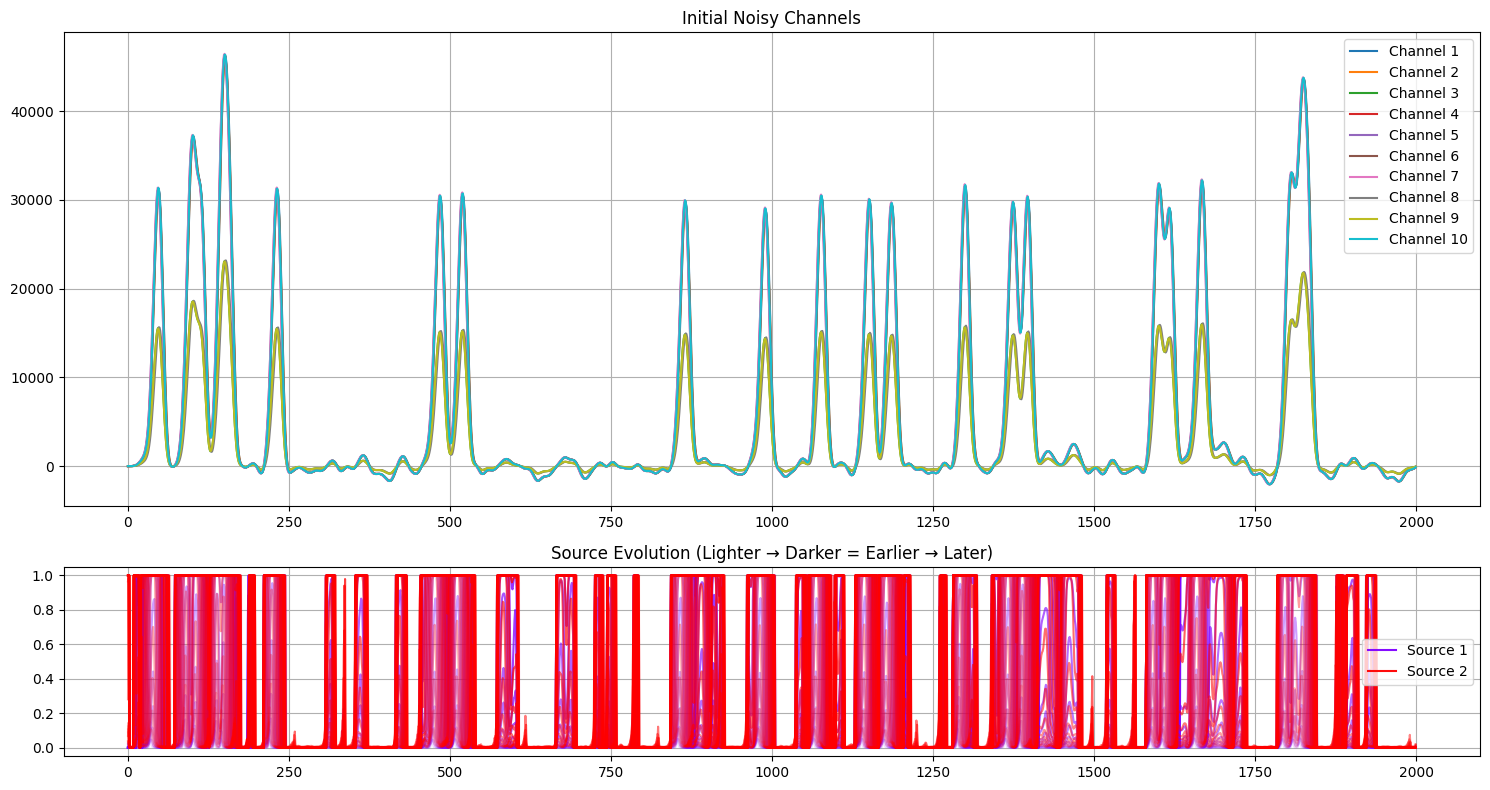

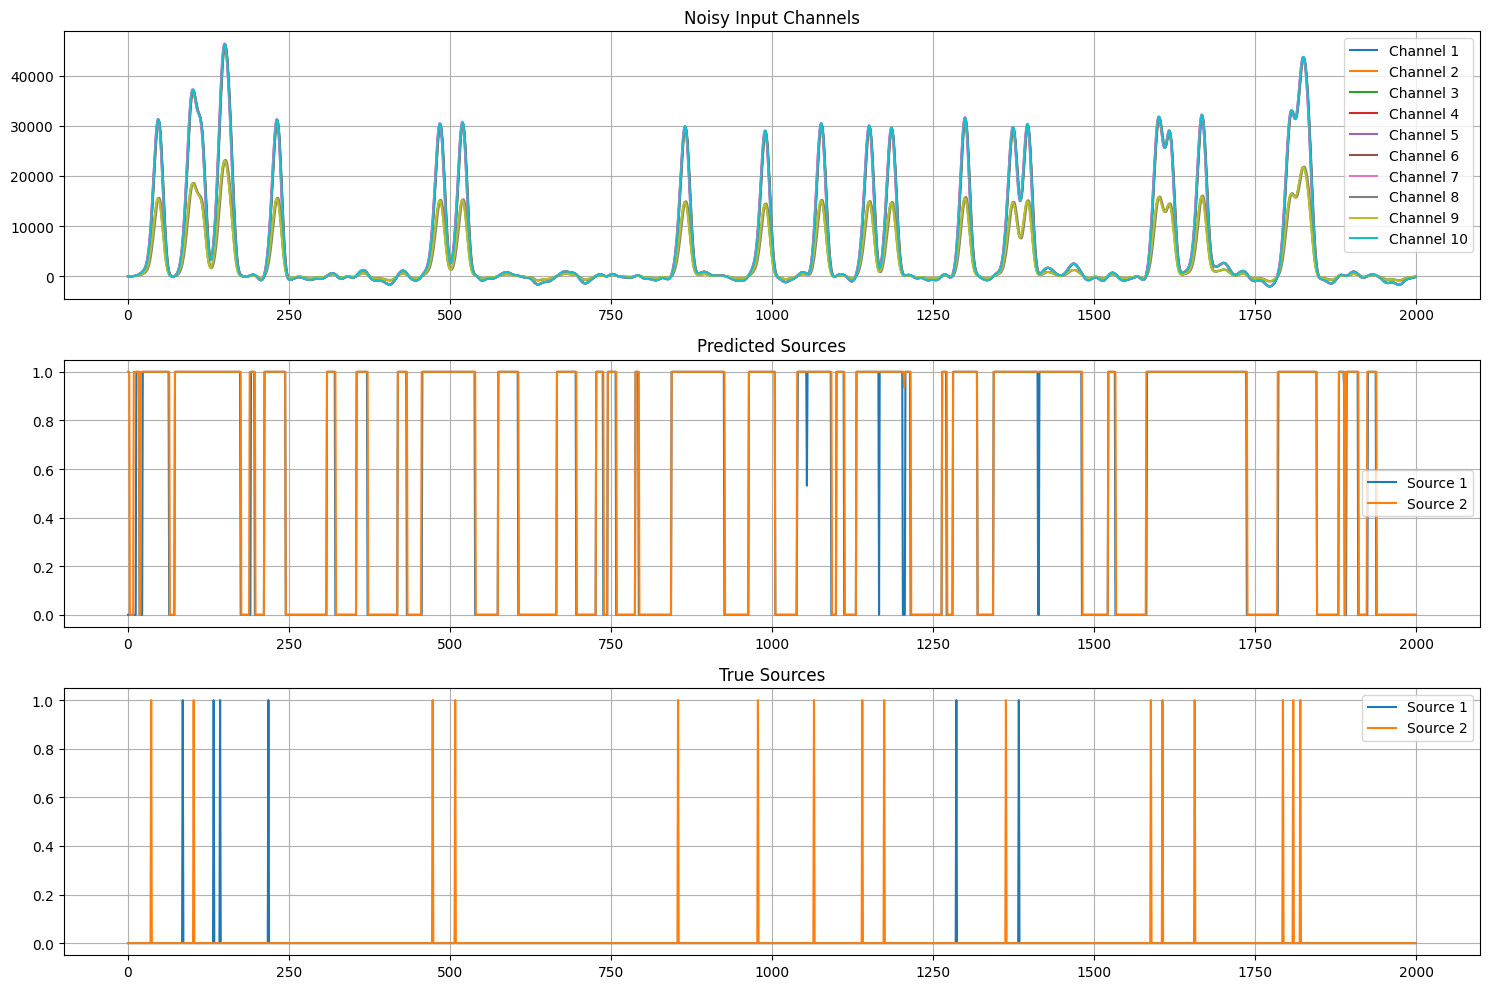

--------------------------------------------------

Example 3:


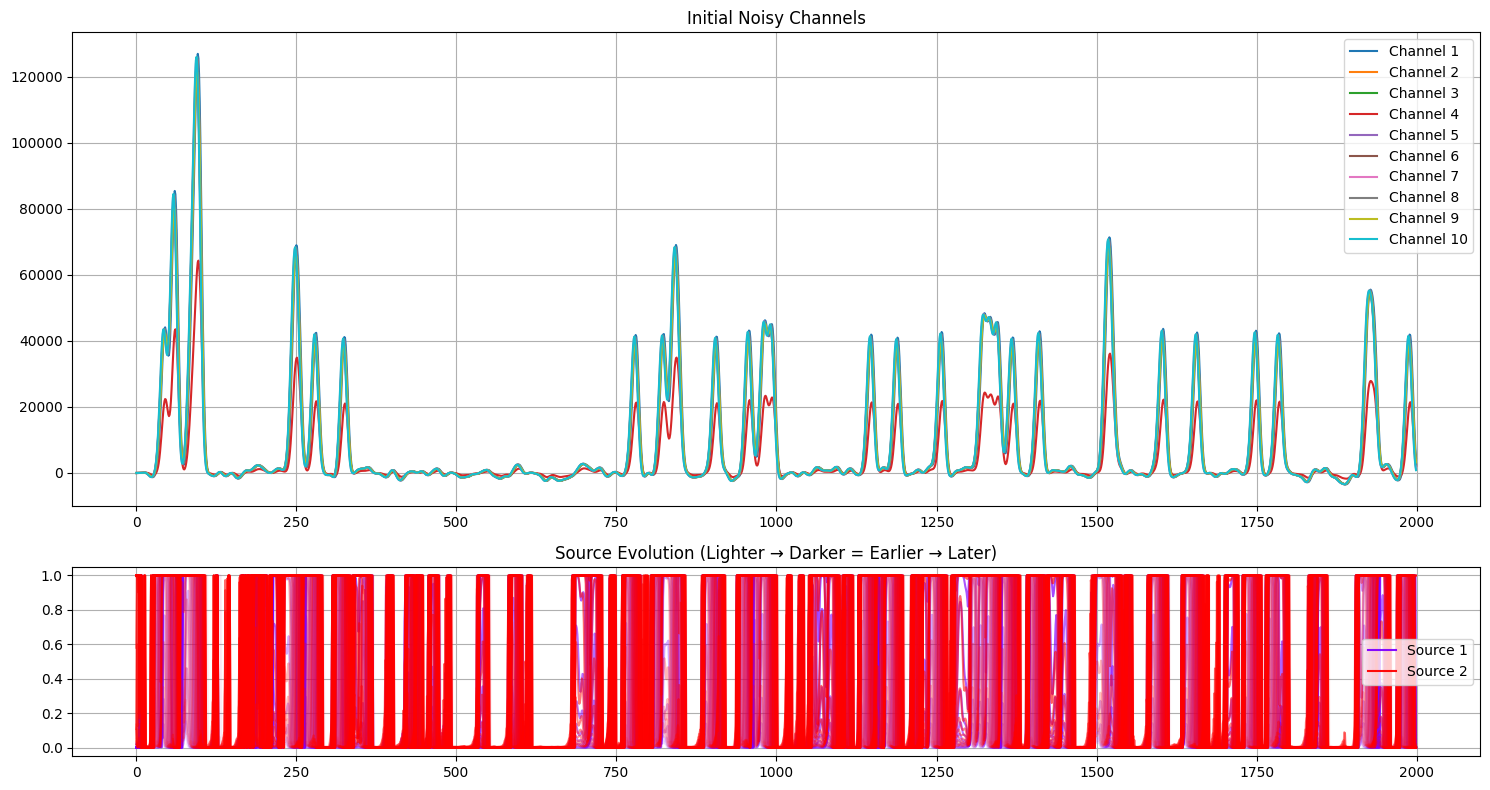

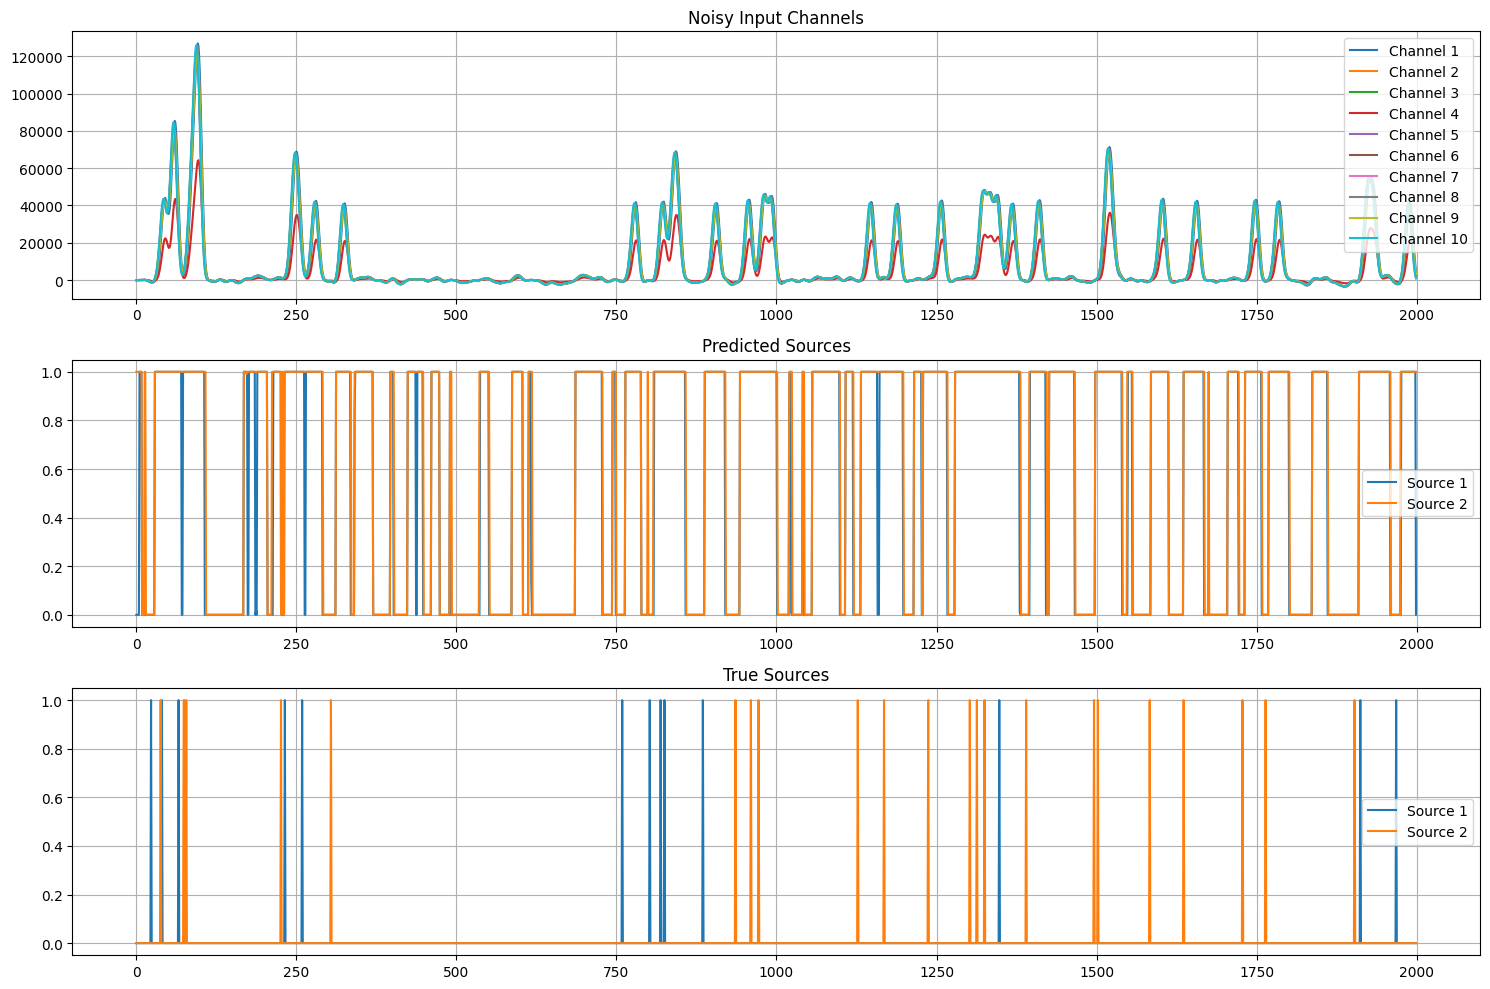

--------------------------------------------------

Example 4:


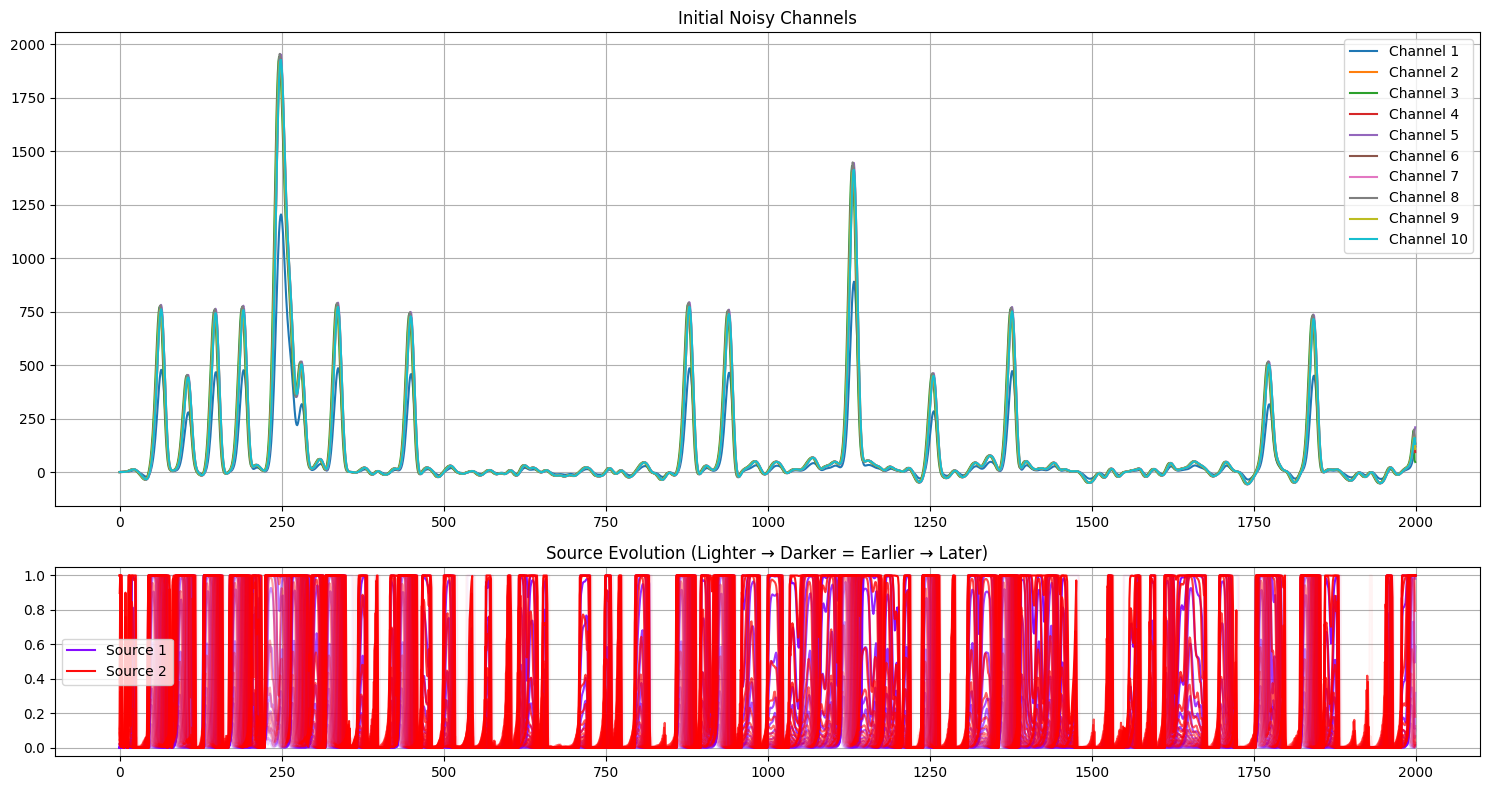

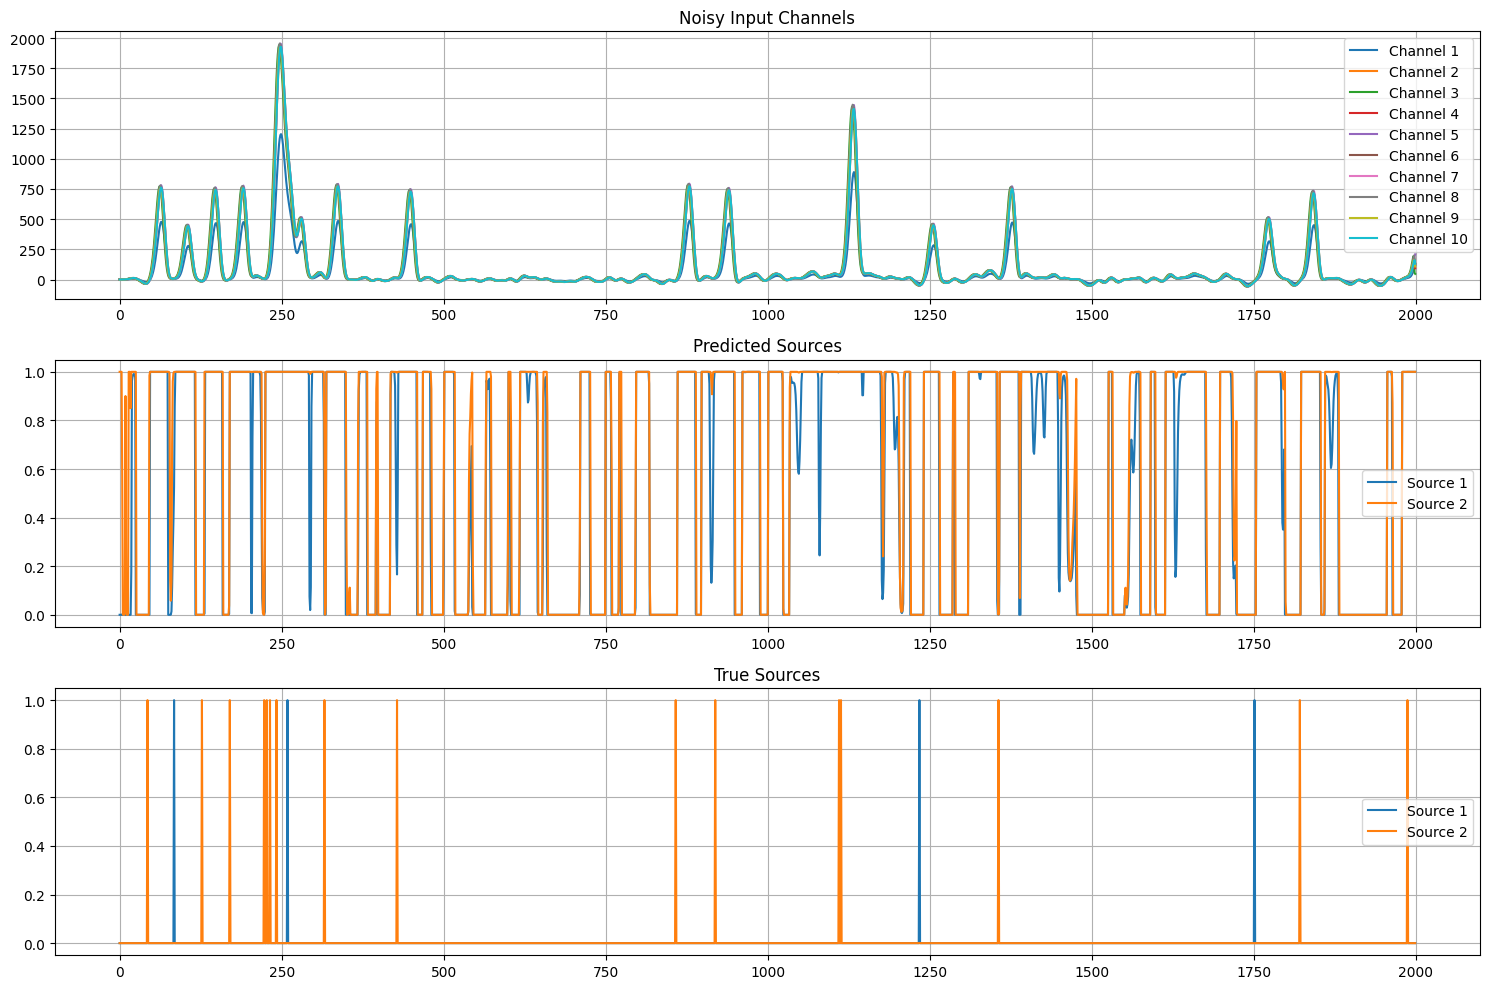

--------------------------------------------------

Example 5:


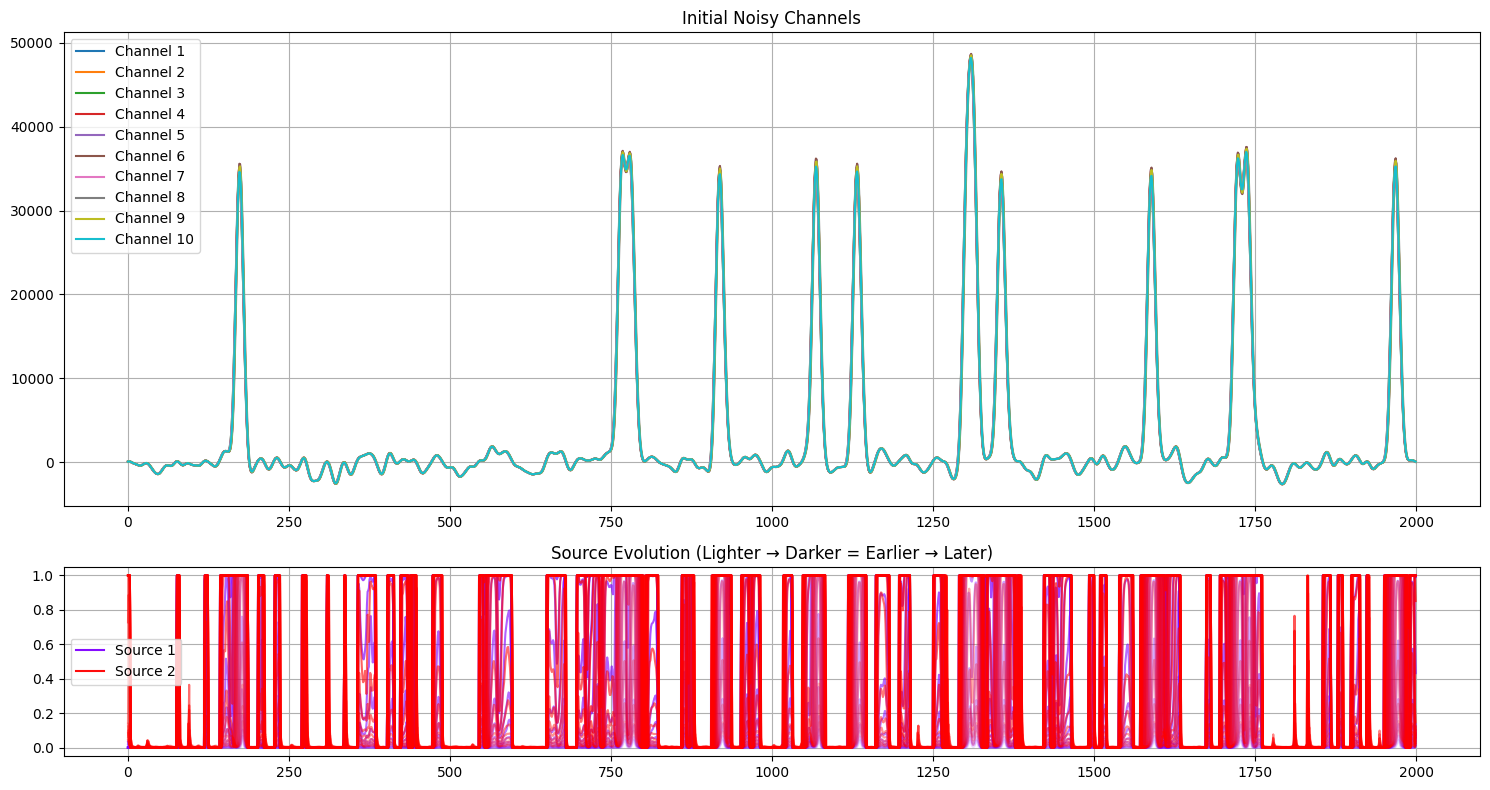

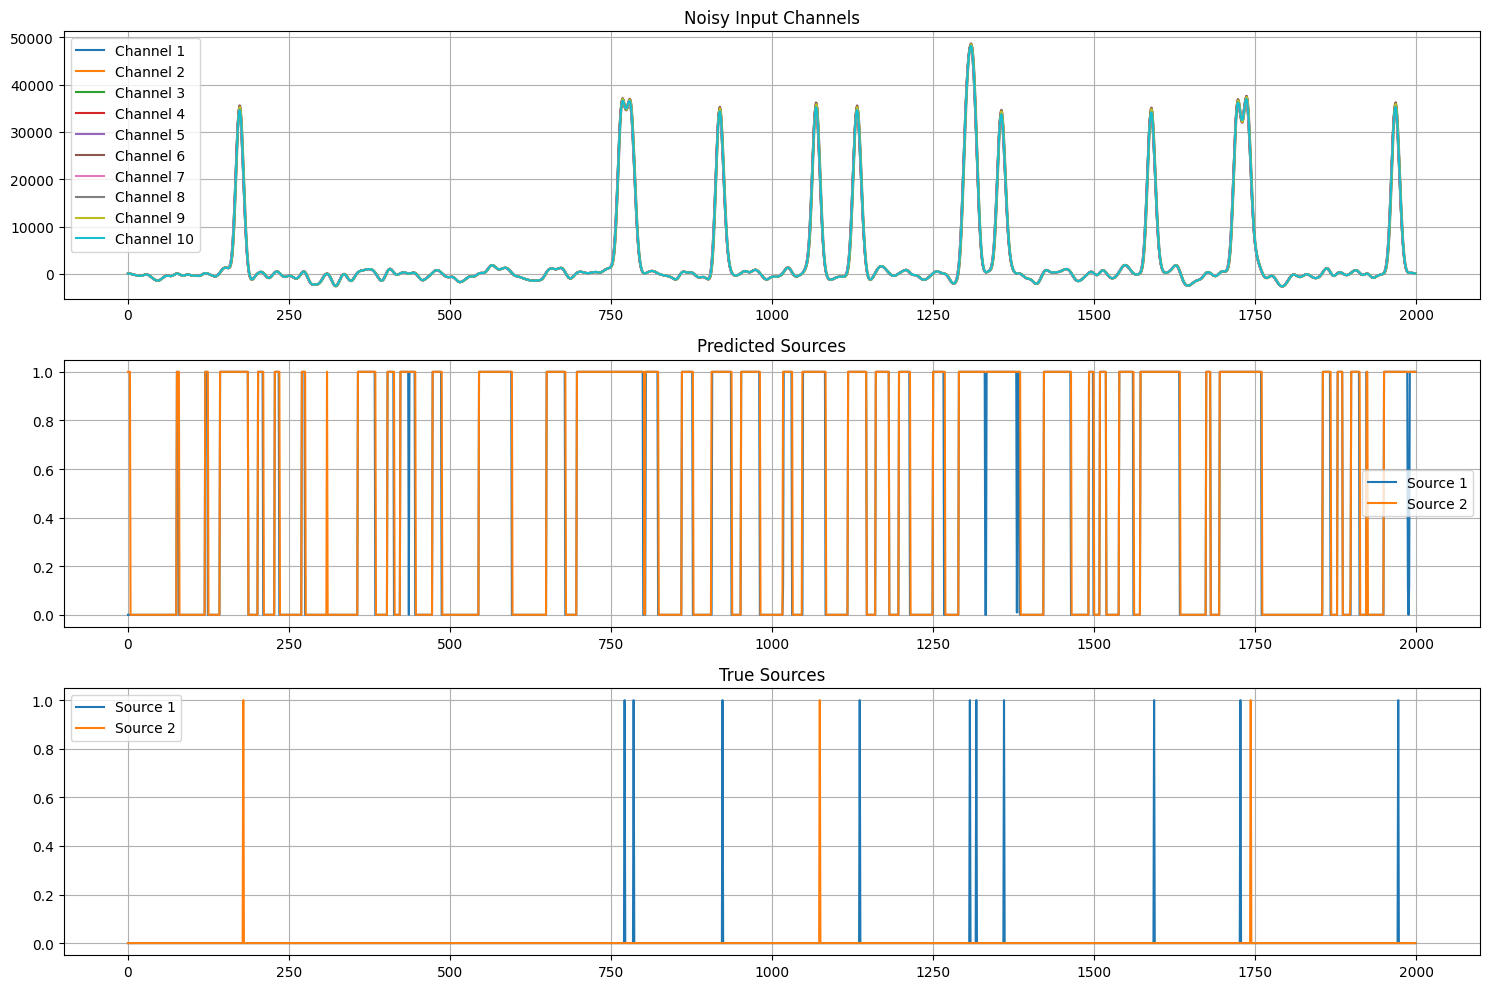

--------------------------------------------------


In [6]:
# Parameters
sources = 2
channels = 10
duration = 20.0
sampling_frequency = 100
num_steps = 20
num_test_examples = 10
noise_std = 0.01
max_iterations = 10000000
test_freq = 100 
lr = 0.001

# Initialize model
model = DeconvolutionDiffusion(sources, channels, duration, sampling_frequency, num_steps, noise_std)

# Train model
trained_model, losses_history = train_model(
    model,
    max_iterations=max_iterations,
    test_freq=test_freq,
    lr=lr
)

# Run testing with visualizations
run_model_with_visualization(model, num_tests=5)

In [ ]:
# epoch based training that worked
# Do not just run like this, it will not work
# this was run without frequency domain processing

def train_model(model, epochs=500, lr=0.001, samples_per_epoch=8):
    """Train the diffusion model for deconvolution with improved stability"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=20, 
        verbose=True
    )
    
    loss_fn = losses.total_loss
    max_grad_norm = 0.5  # Reduced from 1.0 for stability

    # Initialize tracking variables
    start_time = time.time()
    losses_history = []
    best_loss = float('inf')
    patience_counter = 0
    patience = 50  # Early stopping patience

    for epoch in range(epochs):
        epoch_start = time.time()
        epoch_loss = 0
        
        model.train()  # Ensure model is in training mode
        
        # Multiple training samples per epoch
        for sample in range(samples_per_epoch):
            try:
                Y_channel, Y_source = model.generate_training_data()
                optimizer.zero_grad()
                sample_loss = 0
                
                # Clear memory
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                
                # Normalize inputs
                for i in range(len(Y_channel)):
                    Y_channel[i] = (Y_channel[i] - Y_channel[i].mean()) / (Y_channel[i].std() + 1e-8)
                    Y_source[i] = (Y_source[i] - Y_source[i].mean()) / (Y_source[i].std() + 1e-8)
                
                # Progressive loss weighting
                for c in range(1, model.num_steps + 1):
                    Y_pred = model(Y_channel[c-1], c)
                    
                    # Add batch dimension before computing loss
                    Y_pred_batched = Y_pred.unsqueeze(0)
                    Y_source_batched = Y_source[c].unsqueeze(0)
                    
                    # Weight loss more heavily for later steps
                    step_weight = c / model.num_steps
                    step_loss = losses.hungarian_loss(Y_pred_batched, Y_source_batched, loss_fn=loss_fn)
                    sample_loss += step_weight * step_loss
                    
                    del Y_pred, Y_pred_batched, Y_source_batched
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()

                # Normalize the loss
                sample_loss = sample_loss / model.num_steps
                
                # Check for NaN loss
                if torch.isnan(sample_loss):
                    print(f"NaN loss detected in sample {sample}, skipping...")
                    continue
                
                sample_loss.backward()
                
                # Clip gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                
                # Check for NaN gradients
                has_nan_grad = False
                for param in model.parameters():
                    if param.grad is not None and torch.isnan(param.grad).any():
                        has_nan_grad = True
                        break
                
                if not has_nan_grad:
                    optimizer.step()
                else:
                    print(f"NaN gradient detected in sample {sample}, skipping...")
                
                epoch_loss += sample_loss.item()
                
                del sample_loss, Y_channel, Y_source
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                
            except RuntimeError as e:
                print(f"Error in sample {sample}: {str(e)}")
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                continue
        
        # Average loss over all samples in the epoch
        avg_epoch_loss = epoch_loss / samples_per_epoch
        losses_history.append(avg_epoch_loss)
        
        # Learning rate scheduling
        scheduler.step(avg_epoch_loss)
        
        # Early stopping check
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch} epochs")
            break
        
        if epoch % 10 == 0:  # Log every 10 epochs
            elapsed = time.time() - start_time
            epoch_time = time.time() - epoch_start
            eta = (epochs - epoch) * epoch_time
            
            print(f"Epoch {epoch}/{epochs}")
            print(f"Average Training Loss: {avg_epoch_loss:.4f}")
            print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
            print(f"Time per epoch: {epoch_time:.2f}s")
            print(f"Elapsed: {timedelta(seconds=int(elapsed))}")
            print(f"ETA: {timedelta(seconds=int(eta))}")
            print("-" * 50)

    total_time = time.time() - start_time
    print(f"\nTraining completed in {timedelta(seconds=int(total_time))}")
    
    return model, losses_history